In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import tensor, transpose
import numba as nb

In [2]:
from cryo_sbi.inference.priors import get_image_priors
import json

In [3]:
p = get_image_priors(json.load(open("image_params_mixed_training.json")), device="cuda")

TypeError: get_image_priors() missing 1 required positional argument: 'image_config'

In [ ]:
torch.tensor([3.3]).round().long()

tensor([3])

In [34]:
from torch.distributions.distribution import Distribution
class QuatDistribution(Distribution):

    arg_constraints = {}
    has_rsample = True

    def __init__(self):
        
        batch_shape = (1, )
        super().__init__(batch_shape,)

    def rsample(self, sample_shape=torch.Size()):

        shape = self._extended_shape(sample_shape)
        n_quats = shape[0]

        quats = torch.zeros((n_quats, 4))
        count = 0
        while count < n_quats:
            quat = torch.rand(4) * 2.0 - 1.0
            norm = torch.linalg.vector_norm(quat, ord=2)

            if 0.2 <= norm <= 1.0:
                quat /= norm
                quats[count] = quat
                count += 1

        return quats

In [39]:
%timeit QuatDistribution().rsample((1000,))

96.2 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
from typing import Union
import json
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import transforms
from tqdm import tqdm
from lampe.data import JointLoader, H5Dataset
from lampe.inference import NPELoss
from lampe.utils import GDStep
from itertools import islice

In [42]:
torch.tensor([])

tensor([])

In [10]:
def gen_quat() -> torch.Tensor:
    """
    Generate a random quaternion.

    Returns:
        quat (np.ndarray): Random quaternion

    """
    count = 0
    while count < 1:
        quat = 2 * torch.rand(size=(4,)) - 1
        norm = torch.sqrt(torch.sum(quat**2))
        if 0.2 <= norm <= 1.0:
            quat /= norm
            count += 1

    return quat

In [41]:
%timeit test_quats = torch.stack([gen_quat() for _ in range(1)]).cuda()

153 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
models = torch.from_numpy(np.load("../../ceph/covid_spike_data/training_files/spike_models.npy")).repeat(5, 1, 1).to(torch.float32).cuda()
test_quats = torch.stack([gen_quat() for _ in range(len(models))]).cuda()
pixel_size = torch.tensor(2.0, dtype=torch.float32).cuda()
num_pixels = torch.tensor(128, dtype=torch.int64).cuda()
sigma = 2*torch.rand(len(models), dtype=torch.float32).reshape(-1, 1, 1).cuda()

In [12]:
def gen_rot_matrix_batched(quats: torch.Tensor) -> torch.Tensor:
    """
    Generate a rotation matrix from a quaternion.

    Args:
        quat (torch.Tensor): Quaternion

    Returns:
        rot_matrix (torch.Tensor): Rotation matrix
    """

    rot_matrix = torch.zeros((quats.shape[0], 3, 3), device=quats.device)

    rot_matrix[:, 0, 0] = 1 - 2 * (quats[:, 2] ** 2 + quats[:, 3] ** 2)
    rot_matrix[:, 0, 1] = 2 * (quats[:, 1] * quats[:, 2] - quats[:, 3] * quats[:, 0])
    rot_matrix[:, 0, 2] = 2 * (quats[:, 1] * quats[:, 3] + quats[:, 2] * quats[:, 0])

    rot_matrix[:, 1, 0] = 2 * (quats[:, 1] * quats[:, 2] + quats[:, 3] * quats[:, 0])
    rot_matrix[:, 1, 1] = 1 - 2 * (quats[:, 1] ** 2 + quats[:, 3] ** 2)
    rot_matrix[:, 1, 2] = 2 * (quats[:, 2] * quats[:, 3] - quats[:, 1] * quats[:, 0])

    rot_matrix[:, 2, 0] = 2 * (quats[:, 1] * quats[:, 3] - quats[:, 2] * quats[:, 0])
    rot_matrix[:, 2, 1] = 2 * (quats[:, 2] * quats[:, 3] + quats[:, 1] * quats[:, 0])
    rot_matrix[:, 2, 2] = 1 - 2 * (quats[:, 1] ** 2 + quats[:, 2] ** 2)

    return rot_matrix

In [13]:
def project_density_batched(
    coords: torch.Tensor,
    quats: torch.Tensor,
    sigma: torch.Tensor,
    num_pxels: int,
    pixel_size: float,
) -> torch.Tensor:
    """
    Generate a 2D projections from a set of coordinates.

    Args:
        coords (torch.Tensor): Coordinates of the atoms in the images
        sigma (float): Standard deviation of the Gaussian function used to model electron density.
        num_pxels (int): Number of pixels along one image size.
        pixel_size (float): Pixel size in Angstrom

    Returns:
        image (torch.Tensor): Images generated from the coordinates
    """

    num_batch, _, num_atoms = coords.shape
    norm = 1 / (2 * torch.pi * sigma**2 * num_atoms)

    grid_min = -pixel_size * (num_pxels - 1) * 0.5
    grid_max = pixel_size * (num_pxels - 1) * 0.5 + pixel_size

    rot_matrix = gen_rot_matrix_batched(quats)
    grid = torch.arange(grid_min, grid_max, pixel_size, device=coords.device).repeat(coords.shape[0], 1)
    coords_rot = torch.bmm(rot_matrix, coords)
    
    gauss_x = torch.exp_(
            -0.5 * (((grid.unsqueeze(-1) - coords_rot[:, 0, :].unsqueeze(1)) / sigma) ** 2)
        )
    gauss_y = torch.exp_(
            -0.5 * (((grid.unsqueeze(-1) - coords_rot[:, 1, :].unsqueeze(1)) / sigma) ** 2)
        ).transpose(1, 2)
    
    image = torch.bmm(gauss_x, gauss_y) * norm.reshape(-1, 1, 1)

    return image

In [14]:
test_images = project_density_batched(
    models,
    test_quats,
    sigma,
    num_pixels,
    pixel_size,
)

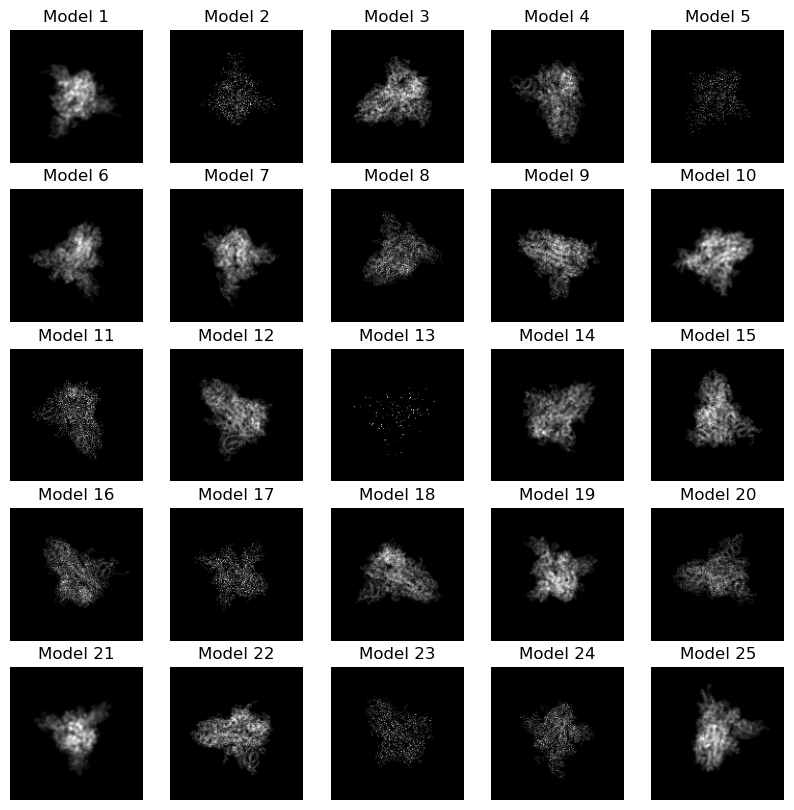

In [15]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(test_images[i].cpu().numpy(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Model {i+1}")

In [16]:
%timeit project_density_batched(models, test_quats, sigma, num_pixels, pixel_size)

37.2 ms ± 4.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
def apply_ctf(image: torch.Tensor, defocus, b_factor, amp, pixel_size) -> torch.Tensor:
    """
    Apply the CTF to an image.

    Args:
        image (torch.Tensor): Image to apply the CTF to
        ctf (torch.Tensor): CTF to apply to the image

    Returns:
        image_ctf (torch.Tensor): Image with the CTF applied
    """

    freq_pix_1d = torch.fft.fftfreq(image.shape[-1], d=pixel_size, device=image.device)

    x, y = torch.meshgrid(freq_pix_1d, freq_pix_1d, indexing="ij")

    freq2_2d = x.to(image.device)**2 + y.to(image.device)**2
    freq2_2d = freq2_2d.expand(image.shape[0], -1, -1)
    imag = torch.zeros_like(freq2_2d, device=image.device) * 1j
    env = torch.exp(-b_factor * freq2_2d * 0.5)
    phase = defocus * torch.pi * 2.0 * 10000 * 0.019
    ctf = (
        -amp * torch.cos(phase * freq2_2d * 0.5)
        - torch.sqrt(1 - amp ** 2) * torch.sin(phase * freq2_2d * 0.5)
        + imag
    )
    ctf = ctf * env / amp

    conv_image_ctf = torch.fft.fft2(image) * ctf
    image_ctf = torch.fft.ifft2(conv_image_ctf).real

    return image_ctf

In [18]:
defocusses = 10 * torch.rand(len(models), dtype=torch.float32).reshape(-1, 1, 1).cuda()
b_factors = 1 * torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).cuda()
amps = 0.1 * torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).cuda()

test_images_ctf = apply_ctf(test_images, defocusses, b_factors, amps, pixel_size)

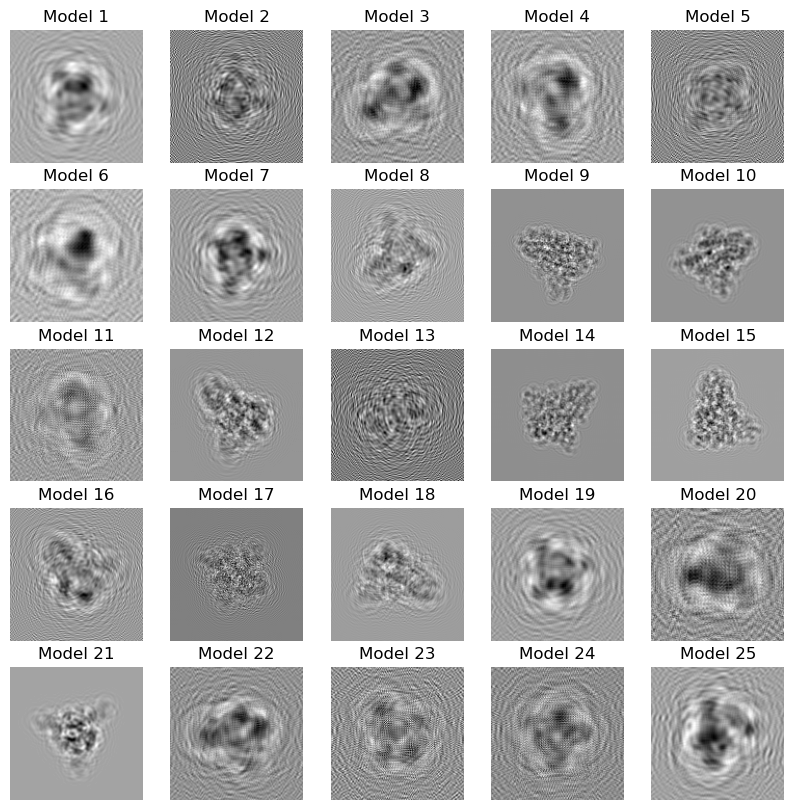

In [19]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(test_images_ctf[i].cpu().numpy(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Model {i+1}")

In [20]:
%timeit test_images_ctf = apply_ctf(test_images, defocusses, b_factors, amps, pixel_size)

3.83 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
def circular_mask(n_pixels: int, radius: int, device: str = "cpu") -> torch.Tensor:
    """
    Creates a circular mask of radius RADIUS_MASK centered in the image

    Args:
        n_pixels (int): Number of pixels along image side.
        radius (int): Radius of the mask.

    Returns:
        mask (torch.Tensor): Mask of shape (n_pixels, n_pixels).
    """

    grid = torch.linspace(
        -0.5 * (n_pixels - 1), 0.5 * (n_pixels - 1), n_pixels, device=device
    )
    r_2d = grid[None, :] ** 2 + grid[:, None] ** 2
    mask = r_2d < radius**2

    return mask


def get_snr(images, snr):
    """
    Computes the SNR of the images

    Args:
        images (torch.Tensor): Images of shape (n_images, n_pixels, n_pixels) or (n_images, n_channels, n_pixels, n_pixels).
        snr (float): SNR to add to the images.

    Returns:
        snr (torch.Tensor): SNR of the images.
    """
    num_batch, num_pixels, _= images.shape
    mask = circular_mask(
        n_pixels=num_pixels,
        radius=64,
        device=images.device,
    )
    signal_power = images[:, mask].pow(2).mean().sqrt()  # torch.std(image[mask])

    noise_power = signal_power / torch.sqrt(snr.to(images.device))

    return noise_power


#@torch.compile
def add_noise(
    image: torch.Tensor, snr, seed= None
) -> torch.Tensor:
    """
    Adds noise to image

    Args:
        image (torch.Tensor): Image of shape (n_pixels, n_pixels).
        image_params (dict): Dictionary with image parameters.
        seed (int, optional): Seed for random number generator. Defaults to None.

    Returns:
        image_noise (torch.Tensor): Image with noise of shape (n_pixels, n_pixels) or (n_channels, n_pixels, n_pixels).
    """

    if seed is not None:
        torch.manual_seed(seed)

    snr = get_snr(image, snr)

    noise = torch.randn_like(image, device=image.device)
    noise = noise * snr.reshape(-1, 1, 1)

    image_noise = image + noise

    return image_noise

In [22]:
snr = 0.5*torch.rand(len(models), dtype=torch.float32).reshape(-1, 1).cuda()

test_images_noise = add_noise(test_images_ctf, snr)

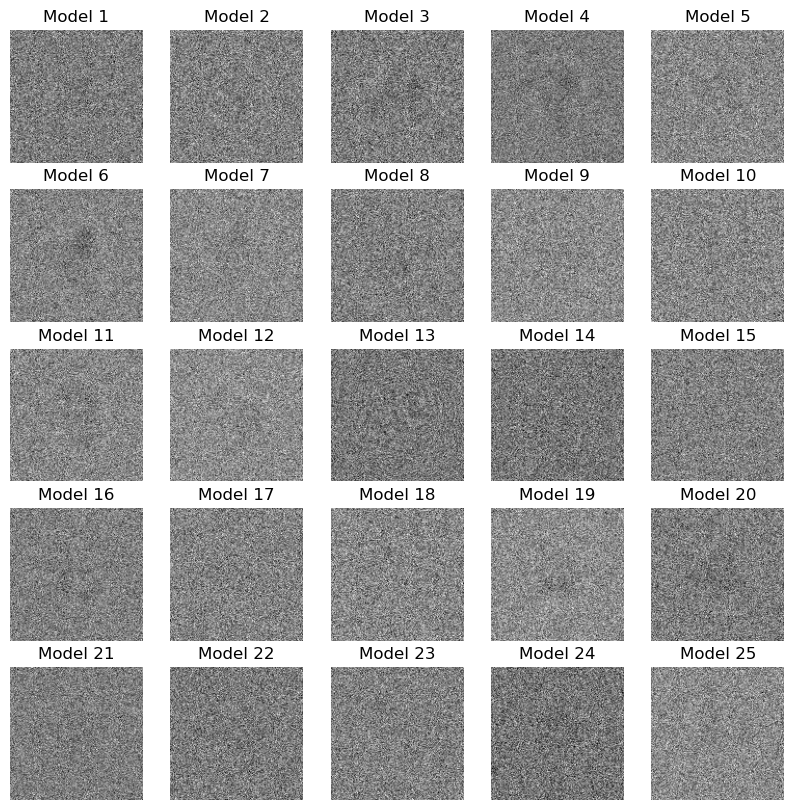

In [23]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(test_images_noise[i].cpu().numpy(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Model {i+1}")

In [24]:
%timeit test_images_noise = add_noise(test_images_ctf, snr)

762 µs ± 37.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
def gpu_simulator(index, quat, sigma, num_pixels, pixel_size, defocus, b_factor, amp, snr):
    image = project_density_batched(
        index,
        quat,
        sigma,
        num_pixels,
        pixel_size,
    )
    image_ctf = apply_ctf(image, defocus, b_factor, amp, pixel_size)
    image_noise = add_noise(image_ctf, snr)
    return image_noise

In [28]:
device = 'cuda'
models = models = torch.from_numpy(np.load("../../ceph/covid_spike_data/training_files/spike_models.npy")).to(torch.float32).repeat(5, 1, 1).to(device)
test_quats = torch.stack([gen_quat() for _ in range(len(models))]).to(device)
test_sigmas = 3*torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).to(device)
test_defocusses = 1 * torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).to(device)
test_b_factors = 1 * torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).to(device)
test_amps = 0.1 * torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).to(device)
test_snrs = torch.rand(len(models), dtype=torch.float32).reshape(-1, 1).to(device)
num_pixels = torch.tensor(128, dtype=torch.int32).to(device)
pixel_size = torch.tensor(2.0, dtype=torch.float32).to(device)
a = torch.ones((len(models), 1), dtype=torch.float32).to(device)
print(models.shape)

test_images = gpu_simulator(models, test_quats, test_sigmas, num_pixels, pixel_size, test_defocusses, test_b_factors, test_amps, test_snrs)

torch.Size([580, 3, 3438])


In [29]:
%timeit gpu_simulator(models, test_quats, test_sigmas, num_pixels, pixel_size, test_defocusses, test_b_factors, test_amps, test_snrs)

38.6 ms ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def load_model(
    train_config: str, model_state_dict: str, device: str, train_from_checkpoint: bool
) -> torch.nn.Module:
    """
    Load model from checkpoint or from scratch.

    Args:
        train_config (str): path to train config file
        model_state_dict (str): path to model state dict
        device (str): device to load model to
        train_from_checkpoint (bool): whether to load model from checkpoint or from scratch
    """
    train_config = json.load(open(train_config))
    estimator = build_npe_flow_model(train_config)
    if train_from_checkpoint:
        if not isinstance(model_state_dict, str):
            raise Warning("No model state dict specified! --model_state_dict is empty")
        print(f"Loading model parameters from {model_state_dict}")
        estimator.load_state_dict(torch.load(model_state_dict))
    estimator.to(device=device)
    return estimator

In [ ]:
estimator = load_model(
    "../notebooks/resnet18_encoder.json", None, train_from_checkpoint=False, device='cuda'
)
estimator
#estimator = torch.jit.trace(estimator, (a, test_images))

In [ ]:
torch.backends.cudnn.benchmark = True


In [ ]:

with tqdm(range(3000), unit="epoch") as tq:
    for epoch in tq:
        for i in range(100):
            gpu_simulator(
                models, 
                test_quats, 
                test_sigmas, 
                num_pixels, 
                pixel_size, 
                test_defocusses, 
                test_b_factors, 
                test_amps, 
                test_snrs
            )

In [ ]:

with tqdm(range(3000), unit="epoch") as tq:
    for epoch in tq:
        losses = torch.stack(
            [
                step(
                    loss(
                        a,
                        test_images
                    )
                )
                for _ in range(100)
            ]
        )

        tq.set_postfix(loss=losses.mean().item())

In [ ]:
loss = NPELoss(estimator)
optimizer = optim.AdamW(estimator.parameters(), lr=0.005)
step = GDStep(optimizer, clip=5)
mean_loss = []

print("Training neural netowrk:")
estimator.train()
with tqdm(range(3000), unit="epoch") as tq:
    for epoch in tq:
        losses = torch.stack(
            [
                step(
                    loss(
                        a,
                        gpu_simulator(
                            models, 
                            test_quats, 
                            test_sigmas, 
                            num_pixels, 
                            pixel_size, 
                            test_defocusses, 
                            test_b_factors, 
                            test_amps, 
                            test_snrs
                        ),
                    )
                )
                for _ in range(100)
            ]
        )

        tq.set_postfix(loss=losses.mean().item())

In [ ]:
for i in range(1, 20):
    device = 'cuda'
    models = models = torch.from_numpy(np.load("../../ceph/covid_spike_data/training_files/spike_models.npy")).to(torch.float32).repeat(i, 1, 1).to(device)
    test_quats = torch.stack([gen_quat() for _ in range(len(models))]).to(device)
    test_sigmas = 3*torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).to(device)
    test_defocusses = 1 * torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).to(device)
    test_b_factors = 1 * torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).to(device)
    test_amps = 0.1 * torch.ones(len(models), dtype=torch.float32).reshape(-1, 1, 1).to(device)
    test_snrs = torch.rand(len(models), dtype=torch.float32).reshape(-1, 1).to(device)
    num_pixels = torch.tensor(128, dtype=torch.int32).to(device)
    pixel_size = torch.tensor(2.0, dtype=torch.float32).to(device)
    a = torch.ones((len(models), 1), dtype=torch.float32).to(device)

    test_images = gpu_simulator(models, test_quats, test_sigmas, num_pixels, pixel_size, test_defocusses, test_b_factors, test_amps, test_snrs)

    loss = NPELoss(estimator)
    optimizer = optim.AdamW(estimator.parameters(), lr=0.005)
    step = GDStep(optimizer, clip=5)
    mean_loss = []

    print("Training neural netowrk:")
    estimator.train()
    with tqdm(range(1), unit="epoch") as tq:
        for epoch in tq:
            losses = torch.stack(
                [
                    step(
                        loss(
                            a,
                            gpu_simulator(
                                models, 
                                test_quats, 
                                test_sigmas, 
                                num_pixels, 
                                pixel_size, 
                                test_defocusses, 
                                test_b_factors, 
                                test_amps, 
                                test_snrs
                            ),
                        )
                    )
                    for _ in range(100)
                ]
            )

            tq.set_postfix(loss=losses.mean().item())

In [5]:
from typing import Union
import json
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import transforms
from tqdm import tqdm
from lampe.data import JointLoader, H5Dataset
from lampe.inference import NPELoss
from lampe.utils import GDStep
from itertools import islice
import matplotlib.pyplot as plt

from cryo_sbi.inference.priors import get_image_priors, PriorLoader
from cryo_sbi.inference.models.build_models import build_npe_flow_model
from cryo_sbi.inference.validate_train_config import check_train_params
from cryo_sbi.wpa_simulator.cryo_em_simulator import cryo_em_simulator

In [6]:
image_config = json.load(open("../../ceph/apoferritin/config_files/image_params_training.json"))
device="cuda"

In [7]:
image_config["SNR"] = [0.1, 0.1]

In [8]:
models = (
    torch.from_numpy(
        np.load("../../ceph/apoferritin/normal_mode_analysis/apo_models.npy"),
    )
    .to(device)
    .to(torch.float32)#[:, 0]
)

In [9]:
models.shape

torch.Size([51, 3, 4080])

In [10]:
image_prior = get_image_priors(len(models) - 1, image_config, device="cpu")
num_pixels = torch.tensor(
    image_config["N_PIXELS"], dtype=torch.float32, device=device
)
pixel_size = torch.tensor(
    image_config["PIXEL_SIZE"], dtype=torch.float32, device=device
)

In [11]:
indices = 25 * torch.ones((100,1))

In [18]:
parameters = image_prior.sample((100,))
indices, quaternions, sigma, defocus, b_factor, amp, snr = parameters
images = cryo_em_simulator(
    models,
    indices.to(device, non_blocking=True),
    quaternions.to(device, non_blocking=True),
    sigma.to(device, non_blocking=True),
    defocus.to(device, non_blocking=True),
    b_factor.to(device, non_blocking=True),
    amp.to(device, non_blocking=True),
    snr.to(device, non_blocking=True),
    num_pixels,
    pixel_size,
)

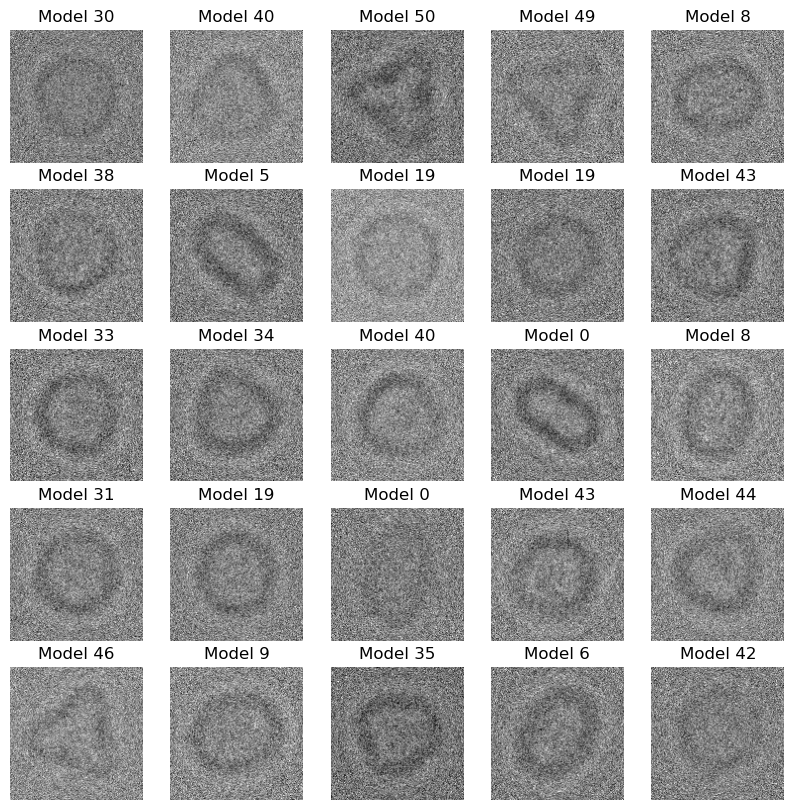

In [19]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].cpu().numpy(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Model {indices[i].round().int().item()}")

In [20]:
import cryo_sbi.utils.estimator_utils as est_utils
import cryo_sbi.utils.image_utils as img_utils
import cryo_sbi.utils.micrograph_utils as mic_utils

In [21]:
estimator = est_utils.load_estimator(
    "../../ceph/apoferritin/config_files/resnet18_fft_encoder.json", 
    "../../ceph/apoferritin/outputs/posterior_apo.estimator",
    device="cuda"
)

In [22]:
samples = est_utils.sample_posterior(
    estimator=estimator,
    images=images,
    num_samples=10000,
    batch_size=100,
    device="cuda",
)

/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


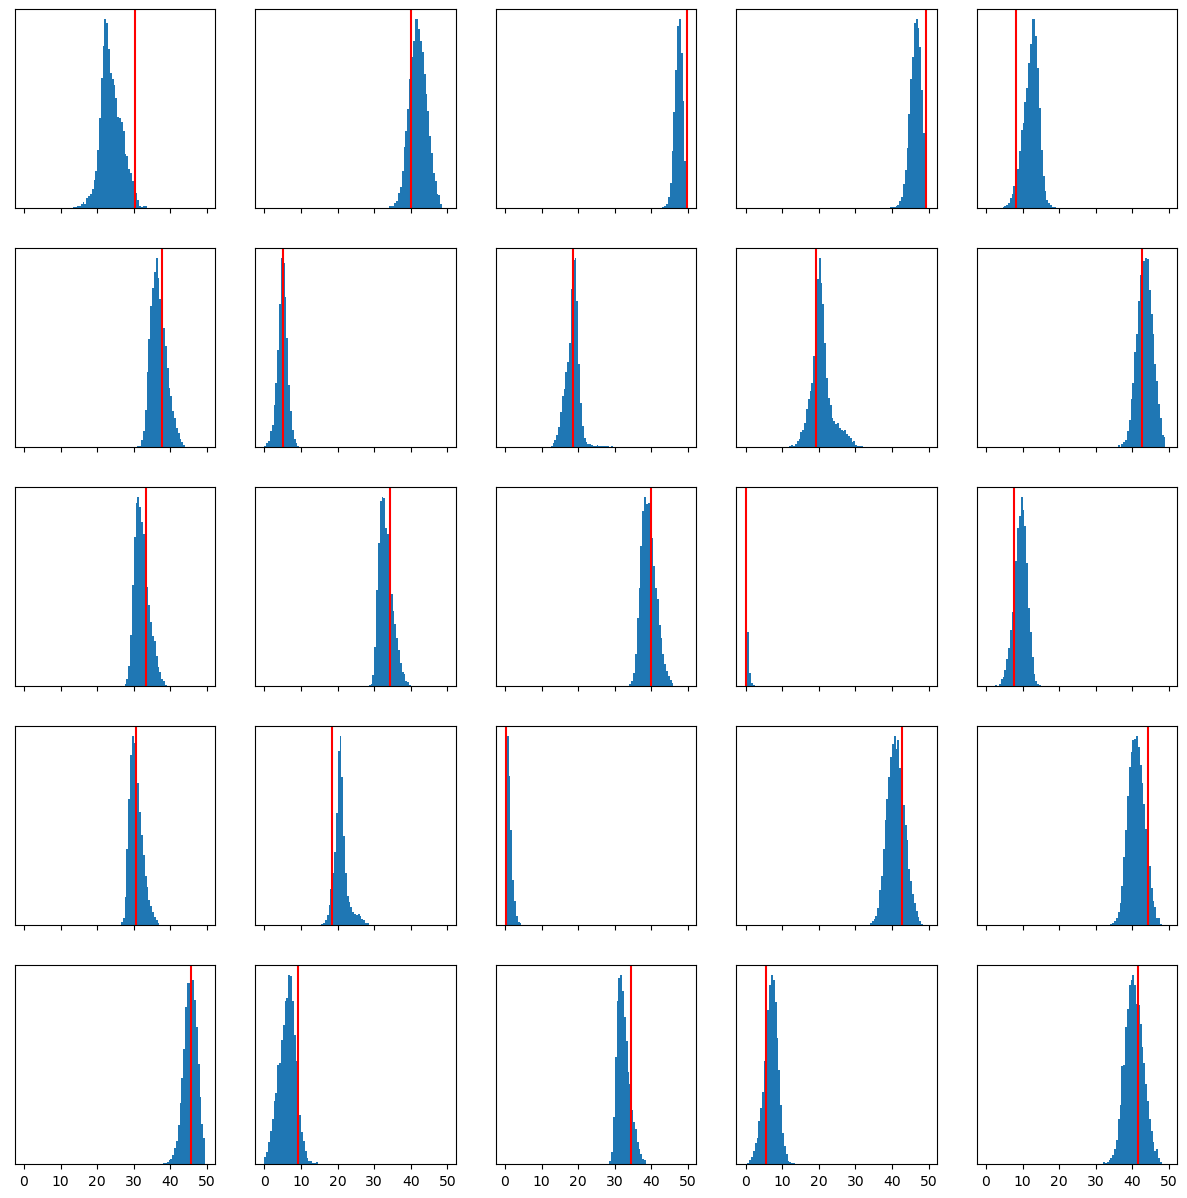

In [23]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True)
for i, ax in enumerate(axes.reshape(-1)):
    ax.hist(samples[:, i], bins=np.arange(0, 50, 0.5))
    ax.axvline(indices[i], color="red")
    ax.set_yticks([])
    ax.set_xticks([0, 10, 20, 30, 40, 50])